<a href="https://colab.research.google.com/github/Suvarnaph/hello-world/blob/master/Capstone_VGG16_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import color
import skimage.transform as skt
import os
import h5py
plt.style.use('default')

Images = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/Images_Shoulder.npy')
labels = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/labels_Shoulder.npy')

In [0]:
Images.shape, labels.shape

((8379,), (8379,))

In [0]:
ImageArr = Images

In [0]:
ImageArr.size

8379

In [0]:
ImageArr.shape[0]

8379

In [0]:
import cv2
rez=(150,150)
def preprocess(data):
  from skimage import exposure
  data_proc = np.zeros((data.shape[0],rez[0],rez[1]))
  for i in range(0, data.shape[0]):
    img = cv2.resize(data[i], rez)
    img=exposure.equalize_hist(img)
    img=(img - img.mean())/(1.0*img.std())
    img=(img-img.min())/(1.0*(1e-2+img.max()-img.min()))	
    data_proc[i,:,:]=img
  return np.array(data_proc)

In [0]:
data_proc = preprocess(ImageArr)

In [0]:
data_proc.shape

(8379, 150, 150)

In [0]:
data_proc.shape[0]

8379

In [0]:
stacked_img = np.stack((data_proc,)*3, axis=-1)
stacked_img.shape

(8379, 150, 150, 3)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
labels.shape, stacked_img.shape

((8379,), (8379, 150, 150, 3))

In [0]:
labels.size, stacked_img.size

(8379, 565582500)

In [0]:
x_train = stacked_img
y_train = labels

In [0]:
#not used
x_train,x_test,y_train,y_test = train_test_split(stacked_img,
                                                             labels, 
                                                             test_size=0.20, 
                                                             random_state=13)

In [0]:
#not used
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((5865, 1), (2514, 1), (5865,), (2514,))

In [0]:
model = conv_base

In [0]:
for layer in model.layers:
   layer.trainable = False

In [0]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
#x = Dropout(0.5)(x)
#x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

In [0]:
import numpy as np
Images_test = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/Images_Shoulder_Valid.npy')
labels_test = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/labels_Shoulder_Valid.npy')
len(Images_test)

563

In [0]:
data_proc = preprocess(Images_test)

In [0]:
stacked_img = np.stack((data_proc,)*3, axis=-1)
stacked_img.shape

(563, 150, 150, 3)

In [0]:
labels_test.shape

(563,)

In [0]:
x_test = stacked_img
y_test  = labels_test

In [0]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((8379, 150, 150, 3), (563, 150, 150, 3), (8379,), (563,))

In [0]:
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping


batch_size = 25
epochs = 50
nb_train_samples = 8379
nb_validation_samples = 563 


model_final = Model(input = model.input, output = predictions)
model_final.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
horizontal_flip = True,
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
horizontal_flip = True,
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow(x_train,y_train,
batch_size = batch_size)

validation_generator = test_datagen.flow(x_test,y_test)

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_Model2.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
train_generator,
samples_per_epoch = x_train.shape[0],
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = 100)
#callbacks = [checkpoint, early])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=<keras_pre..., steps_per_epoch=335, validation_steps=100)`


Epoch 1/50
335/335 [==============================] - 91s 273ms/step - loss: 0.7107 - acc: 0.5273 - val_loss: 0.7079 - val_acc: 0.5120
Epoch 2/50
335/335 [==============================] - 84s 251ms/step - loss: 0.6791 - acc: 0.5648 - val_loss: 0.6705 - val_acc: 0.5820
Epoch 3/50
335/335 [==============================] - 85s 252ms/step - loss: 0.6690 - acc: 0.5871 - val_loss: 0.6549 - val_acc: 0.6198
Epoch 4/50
335/335 [==============================] - 84s 250ms/step - loss: 0.6682 - acc: 0.5908 - val_loss: 0.6638 - val_acc: 0.5782
Epoch 5/50
335/335 [==============================] - 84s 250ms/step - loss: 0.6641 - acc: 0.5990 - val_loss: 0.6514 - val_acc: 0.6217
Epoch 6/50
335/335 [==============================] - 84s 251ms/step - loss: 0.6628 - acc: 0.5980 - val_loss: 0.6639 - val_acc: 0.5663
Epoch 7/50
335/335 [==============================] - 84s 251ms/step - loss: 0.6578 - acc: 0.6030 - val_loss: 0.6375 - val_acc: 0.6421
Epoch 8/50
335/335 [==============================] - 8

In [0]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
import h5py
weights_path =  'drive/My Drive/AIML/Capstone_Team/vgg16_Model.h5' # ('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5)
f = h5py.File(weights_path)

In [0]:
import numpy as np
Images_valid = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/Images_Shoulder_Valid.npy')
labels_valid = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/labels_Shoulder_Valid.npy')
len(Images_valid)

563

In [0]:
data_proc = preprocess(Images_valid)

In [0]:
stacked_img = np.stack((data_proc,)*3, axis=-1)
stacked_img.shape

(563, 150, 150, 3)

In [0]:
from keras.models import load_model
model_validating = load_model('drive/My Drive/AIML/Capstone_Team/vgg16_Model.h5')
model_validating.load_weights('drive/My Drive/AIML/Capstone_Team/vgg16_Model.h5')

ValueError: ignored

In [0]:
prob_pred = model_validating.predict(stacked_img)
labels_final_pred = (prob_pred > 0.5).astype(np.int)
#use value_counts

0.7017165215196264


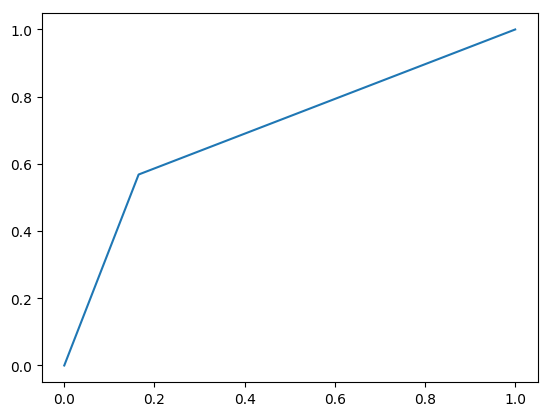

In [0]:
from sklearn import metrics
fpr,tpr, thresh=sklearn.metrics.roc_curve(labels_valid[:], labels_final_pred[:])

plt.plot(fpr,tpr)
print(sklearn.metrics.roc_auc_score(labels_valid[:],labels_final_pred[:]))

In [0]:
fpr, tpr

(array([0.  , 0.16, 1.  ]), array([0.  , 0.57, 1.  ]))

In [0]:
#Classification Report:
from sklearn.metrics import classification_report
y_true = labels_valid
y_pred = labels_final_pred
#target_names = ['Normal', 'Abnormal']
print(classification_report(y_true, y_pred, target_names))

NameError: ignored

In [0]:
from sklearn.metrics import cohen_kappa_score
#This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

In [0]:
#Confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[238,  47],
       [120, 158]])

In [0]:
#counts of true negatives, false positives, false negatives and true positives
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

(238, 47, 120, 158)

In [0]:
w, h = 2, 2;
Matrix = [[0 for x in range(w)] for y in range(h)] 

In [0]:
Matrix[0][0] = 238
Matrix[0][1] = 47
Matrix[1][0] = 120
Matrix[1][1] = 158

ValueError: ignored

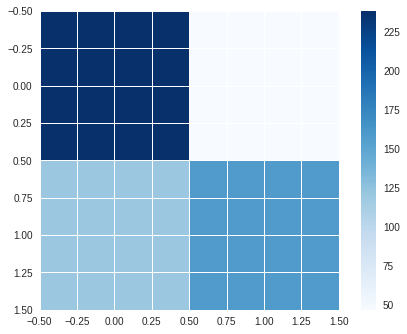

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#cm = metrics.confusion_matrix(y_true, y_pred)
cm = Matrix
title = 'Confusion matrix'
classes = [0,1]

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=([238],[47]),
yticks=([],[]),
# ... and label them with the respective list entries
xticklabels=classes, yticklabels=classes,
title=title,
ylabel='True label',
xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.imshow(cm, cmap=plt.cm.Blues)
#plt.xlabel("Predicted labels")
#plt.ylabel("True labels")
#plt.xticks([],[])
#plt.yticks([],[])
plt.colorbar()
plt.show()

In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = metrics.confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([238], [47])
plt.yticks([120], [158])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

NameError: ignored